#### This notebook potentially can be removed

Contains misc eda stuff. The database structure that is used in this notebook are not relevant anymore. But might contain code that is relevant. 

In [1]:
import os
import sys
project_path = '../'
sys.path.append(project_path)

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from elasticsearch import Elasticsearch

In [3]:
from src.utils.general import get_s3_credentials, get_db_conn

In [4]:
creds_folder = '../conf/local/'
fpath = os.path.join(creds_folder, 'credentials.yaml')

In [335]:
# figures_path = '../data/eda_results'

In [336]:
figures_path = 'images/'

### figure

In [41]:
def setup_figure(fig_size=(15,5)):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_size)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax

### Connections

In [6]:
db_con = get_db_conn(fpath)
es = Elasticsearch([{'host':'localhost','port':9200}])

#### Fetching all bills stored in es

In [12]:
q = "select * from temp_eda.bills_metadata;"
all_bills = pd.read_sql(q, db_con)

#### Fetching bill docs relevant to reproductive rights 

In [9]:
q = "select * from temp_eda.repro_labels_all;"
repro_bill_docs = pd.read_sql(q, db_con)

In [50]:
repro_bill_docs['bill_id'] = repro_bill_docs['bill_id'].astype(int).astype(str)
repro_bill_docs['doc_id'] = repro_bill_docs['doc_id'].astype(int).astype(str)

#### Unique bills ids and their last doc versions in repro

In [65]:
q = "select bill_id, max(doc_date) as last_version_date from temp_eda.repro_labels_all group by bill_id;"
repro_bills = pd.read_sql(q, db_con)
repro_bills['bill_id'] = repro_bills['bill_id'].astype(int).astype(str)

In [196]:
# Merging with the bill_metadata
repro_bills = repro_bills.merge(all_bills, on='bill_id', how='left')

#### Percentage of reproductive rights bills: overall

In [204]:
repro_bill_fraction = repro_bills.shape[0]/all_bills.shape[0]
print('Fraction of reproduction bills, overall: {:.3f}%'.format(repro_bill_fraction*100))

Fraction of reproduction bills, overall: 10.998%


In [333]:
repro_bills.shape[0]

128097

In [334]:
all_bills.shape[0]

1164721

##### Bill count by state

In [35]:
bill_count_by_state = all_bills.groupby('state', as_index=False).count()[['state', 'bill_id']]
bill_count_by_state = bill_count_by_state.rename(columns={'bill_id': 'bill_count'})

In [97]:
bill_count_by_state.sort_values(by='bill_count', ascending=False, inplace=True)

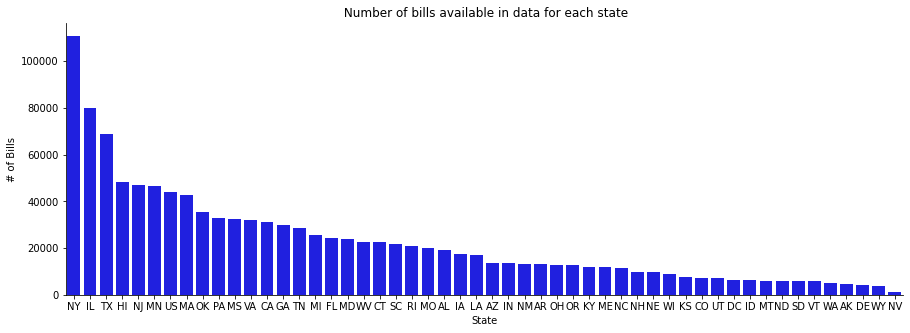

In [99]:
fig, ax = setup_figure((15,5))
sns.barplot(data=bill_count_by_state, x='state', y='bill_count', ax=ax, hue=None, color='blue')
ax.set_ylabel('# of Bills')
ax.set_xlabel('State')
ax.set_title(' Number of bills available in data for each state')

fname = 'bill_numbers_by_state.png'
plt.savefig(os.path.join(figures_path, fname), dpi=300)

# bill_count_by_state.plot(kind)

##### Repro bill count by state

In [72]:
repro_bill_counts_by_state = repro_bills.groupby('state', as_index=False).count()[['state', 'bill_id']]
repro_bill_counts_by_state = repro_bill_counts_by_state.rename(columns={'bill_id': 'bill_count'})

#### Percentage repro bills by state

In [205]:
t1 = repro_bill_counts_by_state.set_index('state')
t2 = bill_count_by_state.set_index('state')

repro_percentages = pd.DataFrame()
repro_percentages['repro_fraction'] = t1['bill_count']/t2['bill_count']
repro_percentages.reset_index(inplace=True)

In [206]:
repro_percentages.sort_values(by='repro_fraction', ascending=False, inplace=True)

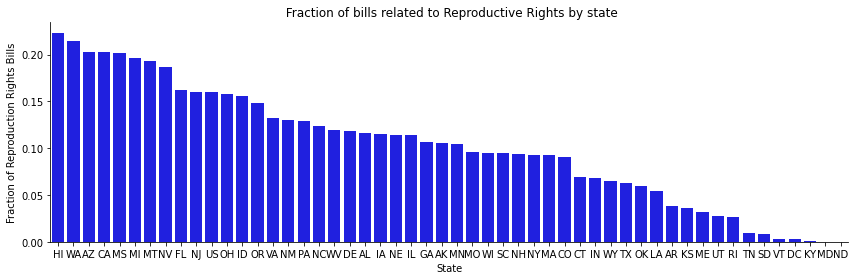

In [346]:
fig, ax = setup_figure((12,4))
sns.barplot(data=repro_percentages, x='state', y='repro_fraction', ax=ax, hue=None, color='blue')
ax.set_ylabel('Fraction of Reproduction Rights Bills')
ax.set_xlabel('State')
ax.set_title(' Fraction of bills related to Reproductive Rights by state')

# fname = 'repro_bill_fraction_by_state.png'
fname = 'eda_1_1_frac.png'
plt.tight_layout()
plt.savefig(os.path.join(figures_path, fname), dpi=300, bbox_inches='tight')

#### Number of reproductive rights bills per year by state

In [195]:
import itertools

In [106]:
repro_bills['bill_year'] = pd.DatetimeIndex(repro_bills['last_version_date']).year

In [165]:
repro_yearly_counts = repro_bills.groupby(['bill_year', 'state'], as_index=False).count()[['bill_year', 'bill_id', 'state']]
repro_yearly_counts = repro_yearly_counts.rename(columns={'bill_id': 'bill_count'})

In [182]:
states = repro_yearly_counts['state'].unique()
years = [2015, 2016, 2017, 2018, 2019]

states_years = [{'state': s, 'year': y} for s, y in itertools.product(states, years)]
states_years = pd.DataFrame(states_years)

In [171]:
msk = repro_yearly_counts['bill_year'] > 2014
repro_yearly_counts = repro_yearly_counts[msk]

In [193]:
repro_yearly_counts_plot = states_years.merge(repro_yearly_counts, left_on=['state', 'year'], right_on=['state', 'bill_year'], how='left')[['state', 'year', 'bill_count']]
repro_yearly_counts_plot = repro_yearly_counts_plot.fillna(0)

In [381]:
yearly_counts_all = all_bills.groupby(['session_year_start', 'state'], as_index=False).count()[['session_year_start', 'bill_id', 'state']]
yearly_counts_all = yearly_counts_all.rename(columns={'bill_id': 'bill_count_all'})

In [382]:
yearly_counts_all_plot = states_years.merge(yearly_counts_all, left_on=['state', 'year'], right_on=['state', 'session_year_start'], how='left')
yearly_counts_all_plot = yearly_counts_all_plot.fillna(0)
yearly_counts_all_plot.drop('session_year_start', axis=1, inplace=True)

In [383]:
# msk2 = yearly_counts_all_plot['year'] > 2014
yearly_counts_all_plot.shape

(215, 3)

In [385]:
combined = repro_yearly_counts_plot.merge(yearly_counts_all_plot, on=['state', 'year'])

In [ ]:
combined.index('bill_count')

In [388]:
combined['fraction'] = combined['bill_count'] / combined['bill_count_all']

In [390]:
combined.head()

,state,year,bill_count,bill_count_all,fraction
0,AK,2015,59.0,752.0,0.078457
1,AK,2016,66.0,0.0,inf
2,AK,2017,22.0,783.0,0.028097
3,AK,2018,12.0,0.0,inf
4,AK,2019,7.0,674.0,0.010386


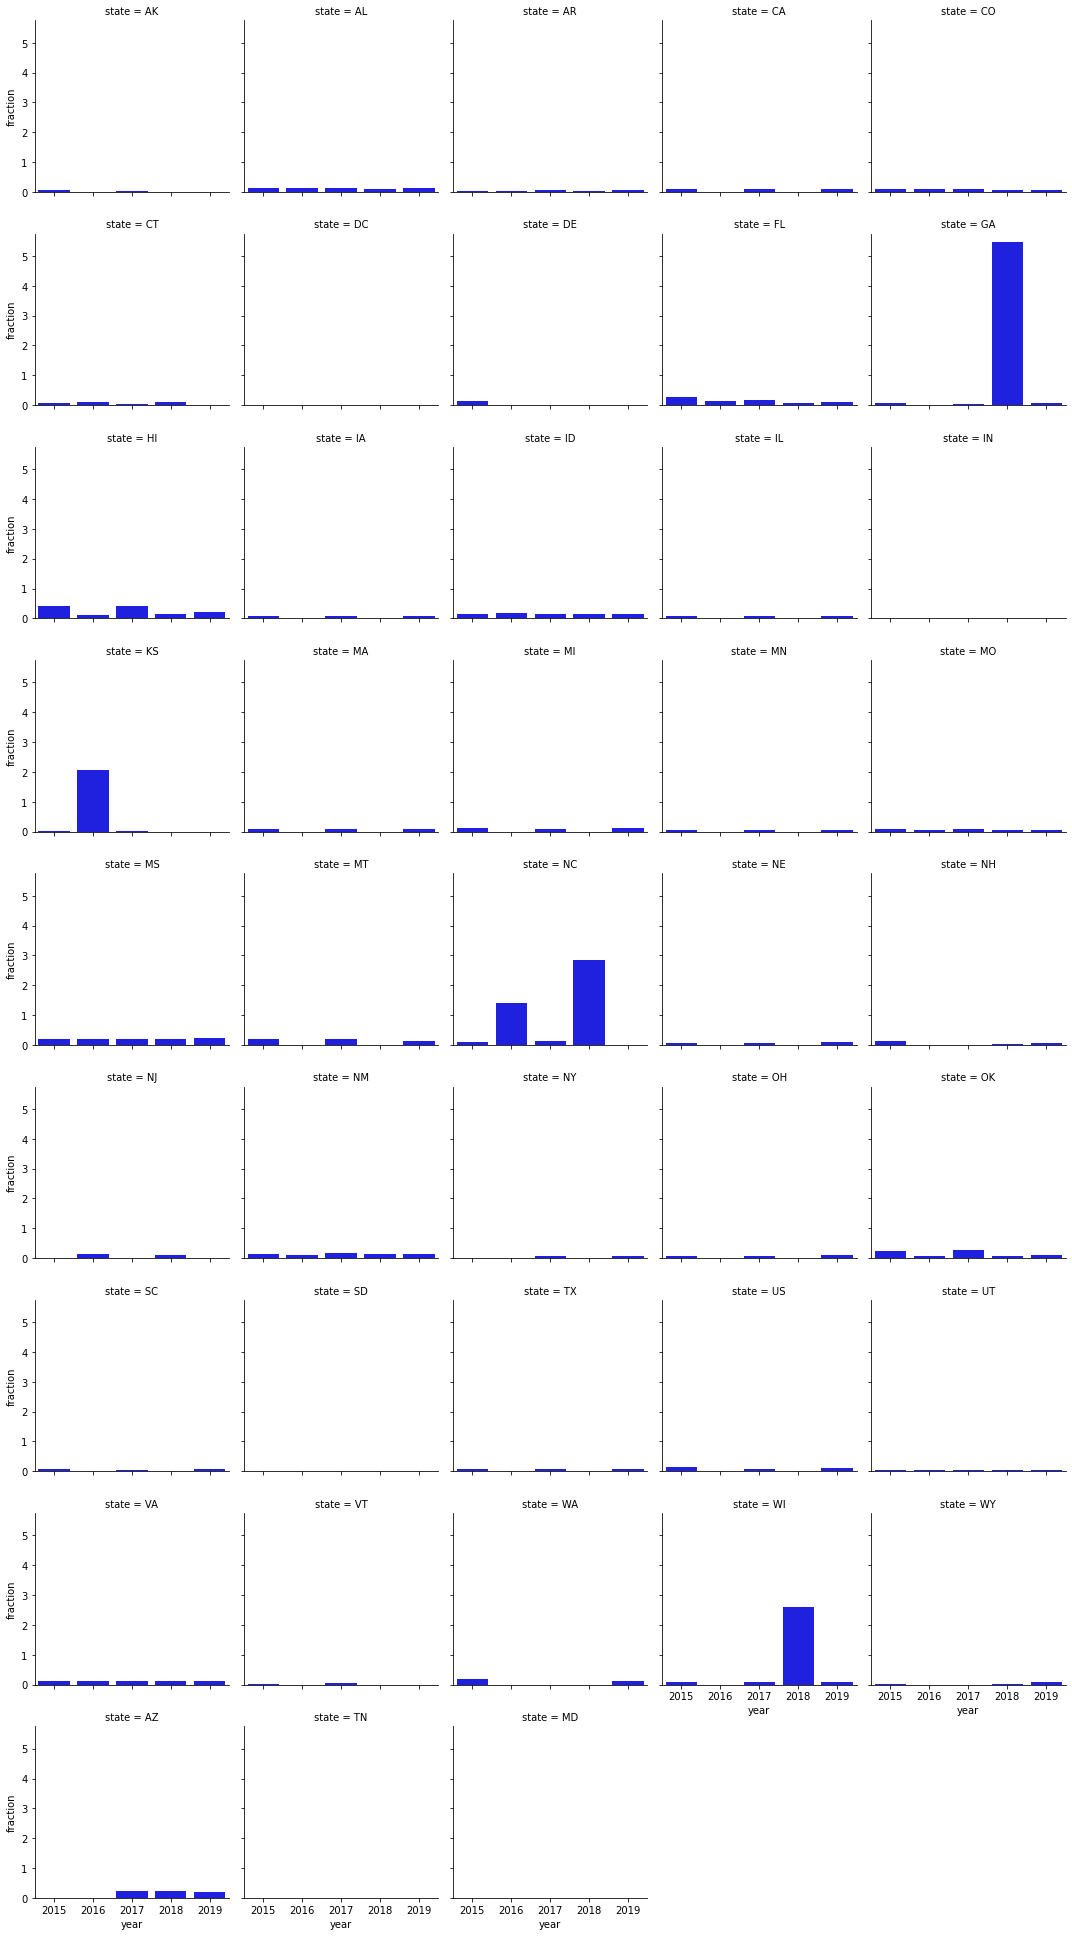

In [389]:
g = sns.FacetGrid(combined, col='state', col_wrap=5, height=3, sharex=True, sharey=True, dropna=False)
g = g.map(sns.barplot, 'year', 'fraction', color='blue')
# fname = 'repro_bill_by_year_and_state.png'
# fname = 'eda_1_2_frac_time.png'
plt.savefig(os.path.join(figures_path, fname), dpi=300, bbox_inches='tight')

### Bill versions

#### Versions across all bills

In [318]:
q = "select bill_id, count(*) as num_versions, min(doc_date) as intro_date, max(doc_date) as last_date from temp_eda.bill_docs group by bill_id"
all_bill_docs = pd.read_sql(q, db_con)
all_bill_docs['bill_id'] = all_bill_docs['bill_id'].astype(int).astype(str)

In [319]:
all_bill_docs.shape

(1133827, 4)

Text(0.5, 1.0, 'Distribution of version counts of bills')

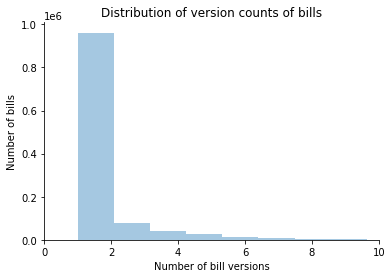

In [320]:
# all_bill_docs['num_versions'].hist(bins=100)
# plt.xlim(0, 10)

fig, ax = setup_figure((6, 4))
sns.distplot(all_bill_docs['num_versions'], kde=False, ax=ax)
ax.set_xlim(0,10)
# ax.set_ylim(0)
ax.set_xlabel('Number of bill versions')
ax.set_ylabel('Number of bills')
ax.set_title('Distribution of version counts of bills')

#### Bill version distribution for the issue area

In [248]:
q = "select bill_id, count(*) as num_versions, min(doc_date) as intro_date, max(doc_date) as last_date from temp_eda.repro_labels_all group by bill_id;"

repro_bill_versions = pd.read_sql(q, db_con)
repro_bill_versions['bill_id'] = repro_bill_versions['bill_id'].astype(int).astype(str)

Text(0.5, 1.0, 'Distribution of version counts for Reproductive Rights bills')

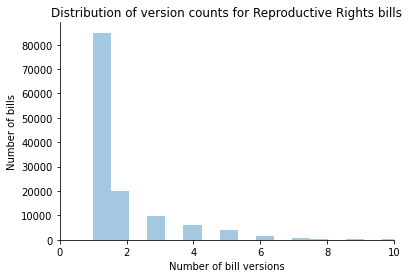

In [249]:
fig, ax = setup_figure((6, 4))
sns.distplot(repro_bill_versions['num_versions'], kde=False, ax=ax)
ax.set_xlim(0,10)
# ax.set_ylim(0)
ax.set_xlabel('Number of bill versions')
ax.set_ylabel('Number of bills')
ax.set_title('Distribution of version counts for Reproductive Rights bills')

### Version changes with time

In [254]:
repro_bill_versions['intro_year'] = pd.DatetimeIndex(repro_bill_versions['intro_date']).year
repro_bill_versions['last_year'] = pd.DatetimeIndex(repro_bill_versions['last_date']).year

In [262]:
msk = repro_bill_versions['intro_year'] > 2014

In [329]:
# fig, ax = plt.subplots()
# sns.lineplot(x='intro_year', y='num_versions', data=repro_bill_versions, marker='o')
# ax.set_xlim(2010, 2019)

##### For all bills

In [321]:
all_bill_docs['intro_year'] = pd.DatetimeIndex(all_bill_docs['intro_date']).year
all_bill_docs['last_year'] = pd.DatetimeIndex(all_bill_docs['last_date']).year

In [322]:
all_bill_docs = all_bill_docs.merge(all_bills, on='bill_id', how='left')

In [324]:
msk = (all_bill_docs['session_year_start'] > 2014) & (all_bill_docs['session_year_start'] < 2021) 

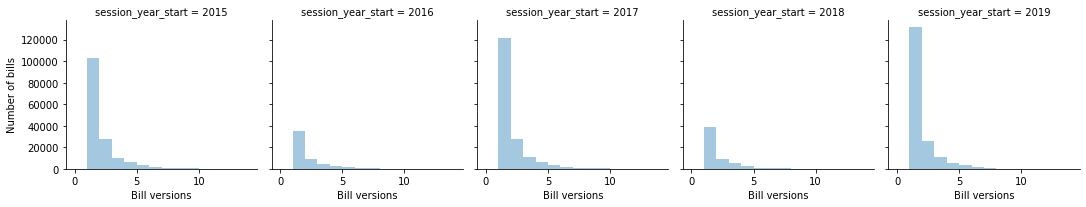

In [328]:
bins = np.arange(0, 15, 1)
g = sns.FacetGrid(all_bill_docs[msk], col='session_year_start', col_wrap=5, sharex=True, sharey=True, dropna=False)
g = g.map(sns.distplot, 'num_versions', kde=False, bins=bins)
g.set_ylabels('Number of bills')
g.set_xlabels('Bill versions')

### Version number distribution across states

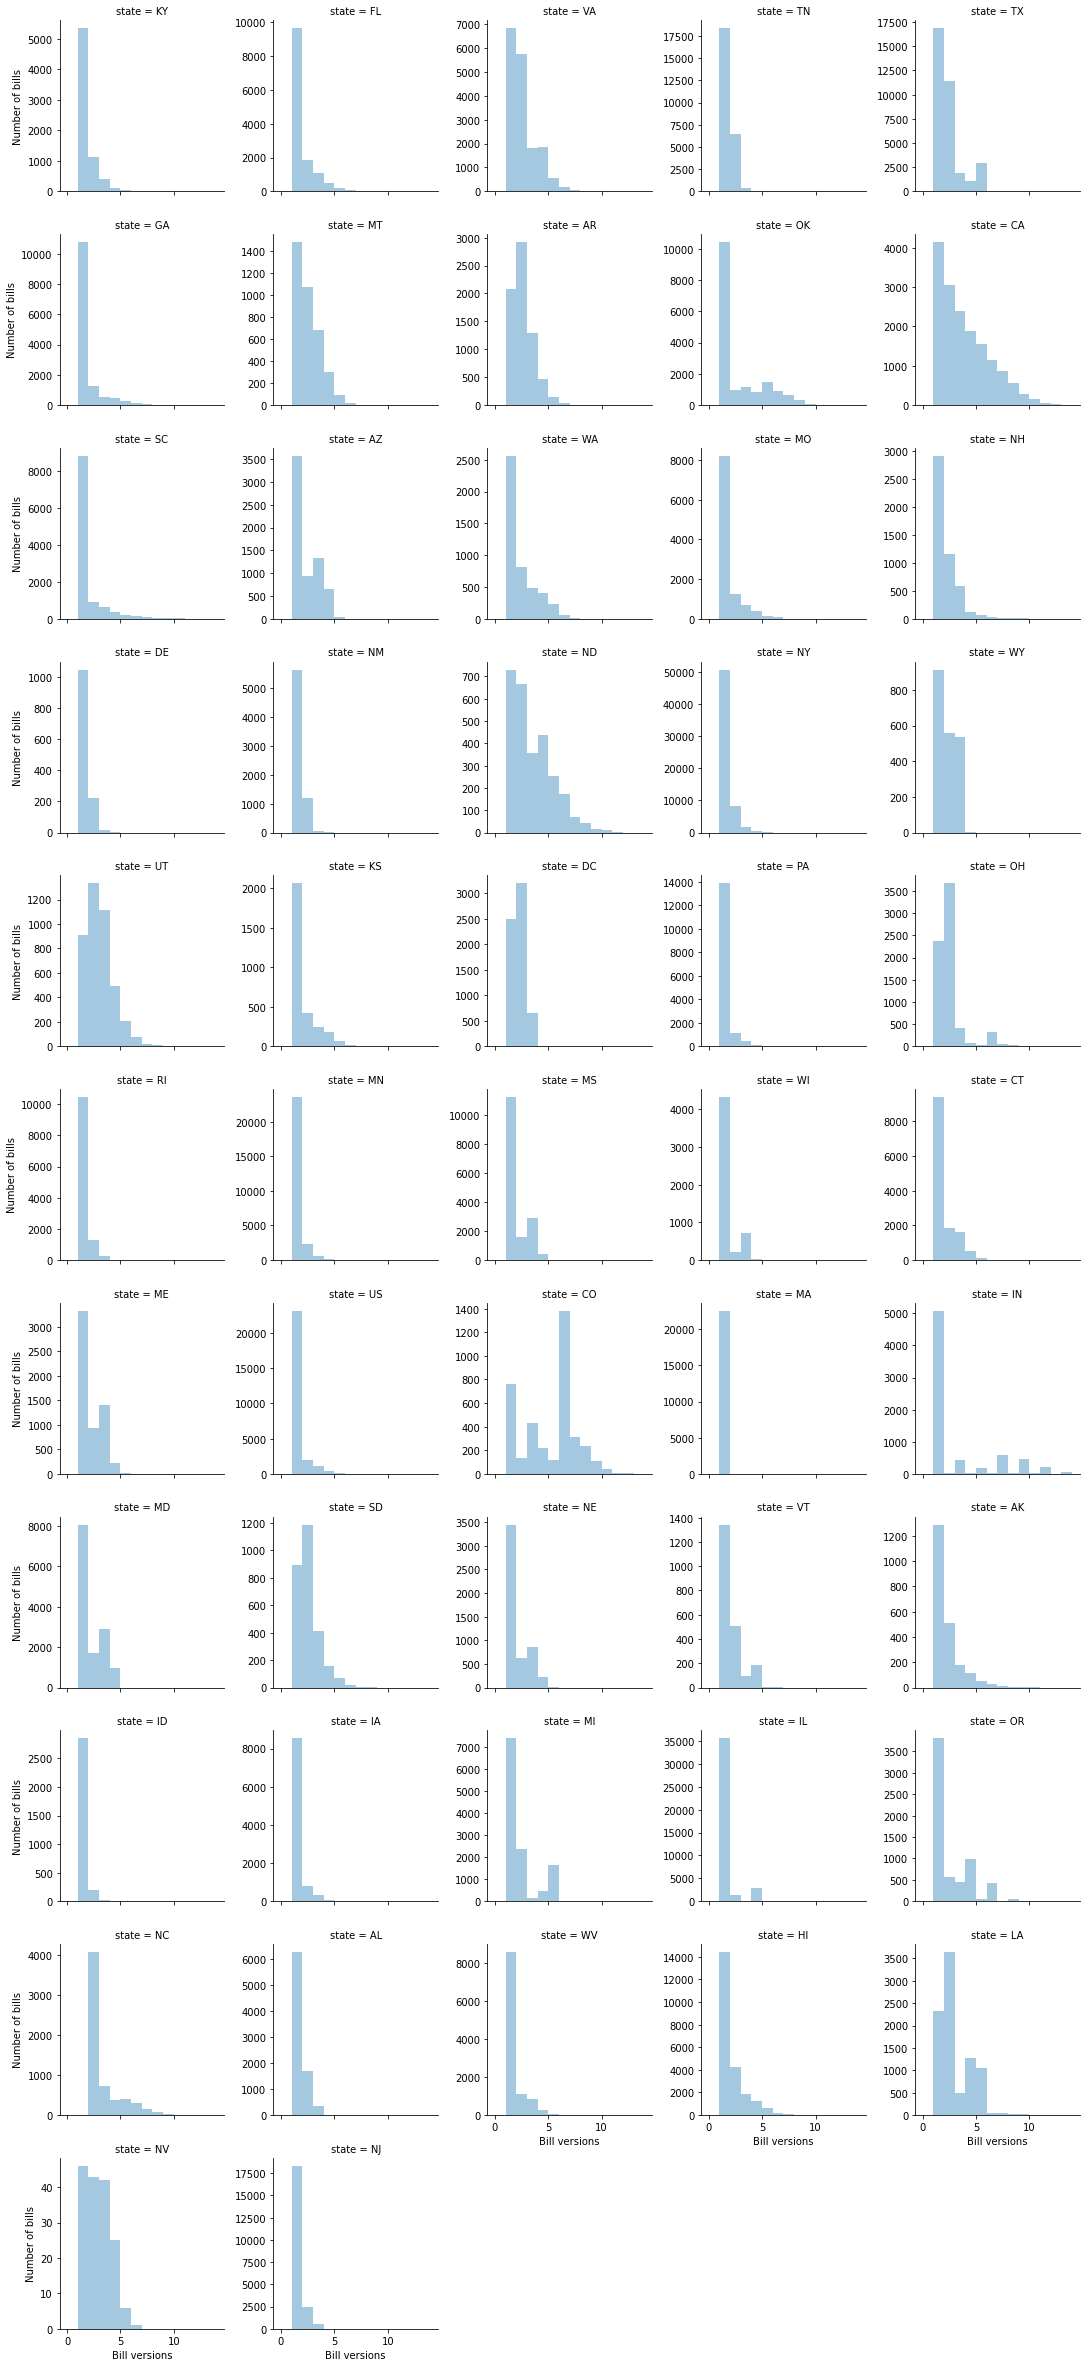

In [332]:
bins = np.arange(0, 15, 1)
g = sns.FacetGrid(all_bill_docs[msk], col='state', col_wrap=5, sharex=True, sharey=False, dropna=False)
g = g.map(sns.distplot, 'num_versions', kde=False, bins=bins)
g.set_ylabels('Number of bills')
g.set_xlabels('Bill versions')

In [1]:
from wordcloud import WordCloud, STOPWORDS